In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from pandas.tseries.offsets import DateOffset
warnings.filterwarnings('ignore')

In [74]:
confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
recovered_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
death_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [75]:
def get_n_melt_data(data_url, case_type):
    df = pd.read_csv(data_url)
    reshape_df = df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"])
    reshape_df.rename(columns={"variable": "Date", "value": case_type}, inplace=True)
    return reshape_df

def merge_data(confirmed, recovered, deaths):
    new_df = confirmed.join(recovered["Recovered"]).join(deaths["Deaths"])
    return new_df

def fetch_data():
    confirm_df = get_n_melt_data(confirmed_cases_url, "Confirmed")
    recovered_df = get_n_melt_data(recovered_cases_url, "Recovered")
    deaths_df = get_n_melt_data(death_cases_url, "Deaths")
    print("Getting and Reshaping Data")
    df = merge_data(confirm_df, recovered_df, deaths_df)
    print("Preview")
    print(df.tail(5))
    #filename= "covid19_dataset_{}.csv".format(timestr)
    filename= "./covid19_dataset.csv"
    print("Saving Data as {}".format(filename))
    df.to_csv(filename)
    print("Done")

fetch_data()


Getting and Reshaping Data
Preview
                    Province/State         Country/Region       Lat  \
20772  Falkland Islands (Malvinas)         United Kingdom -51.79630   
20773    Saint Pierre and Miquelon                 France  46.88520   
20774                          NaN            South Sudan   6.87700   
20775                          NaN         Western Sahara  24.21550   
20776                          NaN  Sao Tome and Principe   0.18636   

            Long    Date  Confirmed  Recovered  Deaths  
20772 -59.523600  4/9/20          5        NaN       0  
20773 -56.315900  4/9/20          1        NaN       0  
20774  31.307000  4/9/20          3        NaN       0  
20775 -12.885800  4/9/20          4        NaN       0  
20776   6.613081  4/9/20          4        NaN       0  
Saving Data as ./covid19_dataset.csv
Done


In [76]:
filename= "./covid19_dataset.csv"
df = pd.read_csv(filename)
df.rename(columns={df.columns[0]: 'Index','Province/State': 'Province_State', 'Country/Region': 'Country_Region'}, inplace=True)
df = df[['Province_State', 'Country_Region', 'Lat', 'Long', 'Date', 'Confirmed', 'Recovered', 'Deaths']]
df2 = df
df['cases_dates'] =  pd.to_datetime(df2['Date'])
df.head()
df_by_date = df2.set_index('cases_dates').groupby(['cases_dates']).sum().reset_index(drop=None)
df = df_by_date[['cases_dates','Confirmed', 'Recovered','Deaths']]
df.head()

,cases_dates,Confirmed,Recovered,Deaths
0,2020-01-22,555,28.0,17
1,2020-01-23,654,30.0,18
2,2020-01-24,941,38.0,26
3,2020-01-25,1434,83.0,42
4,2020-01-26,2118,63.0,56


In [77]:
df.cases_dates = pd.to_datetime(df.cases_dates)
df = df.set_index('cases_dates')
df = df[['Confirmed']].diff().fillna(0)
df = df.iloc[1:]


In [78]:
df.head()

,Confirmed
cases_dates,
2020-01-23,99.0
2020-01-24,287.0
2020-01-25,493.0
2020-01-26,684.0
2020-01-27,809.0


In [79]:
train, test = train_test_split(df, test_size=0.5, shuffle=False)

In [80]:
scaler =  MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [81]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, test, length=n_input, batch_size=6)
model = Sequential()
model.add(LSTM(200, activation="relu", input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.fit_generator(generator, epochs=200)

Epoch 1/200
5/5 [==============================] - 1s 101ms/step - loss: 16.8237
Epoch 2/200
5/5 [==============================] - 0s 14ms/step - loss: 16.1080
Epoch 3/200
5/5 [==============================] - 0s 21ms/step - loss: 14.8051
Epoch 4/200
5/5 [==============================] - 0s 14ms/step - loss: 11.4783
Epoch 5/200
5/5 [==============================] - 0s 13ms/step - loss: 5.0805
Epoch 6/200
1/5 [=====>........................] - ETA: 0s - loss: 2.3105/5 [==============================] - 0s 13ms/step - loss: 3.5817
Epoch 7/200
5/5 [==============================] - 0s 14ms/step - loss: 4.3601
Epoch 8/200
5/5 [==============================] - 0s 13ms/step - loss: 3.8970
Epoch 9/200
5/5 [==============================] - 0s 11ms/step - loss: 4.7740
Epoch 10/200
5/5 [==============================] - 0s 12ms/step - loss: 3.1286
Epoch 11/200
5/5 [==============================] - 0s 13ms/step - loss: 4.2649
Epoch 12/200
5/5 [==============================] - 0s 13ms/step

In [82]:
pred_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis=1)
    

In [83]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=df[-n_input:].index, columns=['Predictions'])
df_test = pd.concat([df, df_predict], axis=1)
print(tabulate(df_test))

-------------------  ------  -------
2020-01-23 00:00:00      99    nan
2020-01-24 00:00:00     287    nan
2020-01-25 00:00:00     493    nan
2020-01-26 00:00:00     684    nan
2020-01-27 00:00:00     809    nan
2020-01-28 00:00:00    2651    nan
2020-01-29 00:00:00     588    nan
2020-01-30 00:00:00    2068    nan
2020-01-31 00:00:00    1693    nan
2020-02-01 00:00:00    2111    nan
2020-02-02 00:00:00    4749    nan
2020-02-03 00:00:00    3094    nan
2020-02-04 00:00:00    4011    nan
2020-02-05 00:00:00    3743    nan
2020-02-06 00:00:00    3159    nan
2020-02-07 00:00:00    3597    nan
2020-02-08 00:00:00    2729    nan
2020-02-09 00:00:00    3030    nan
2020-02-10 00:00:00    2612    nan
2020-02-11 00:00:00    2040    nan
2020-02-12 00:00:00     419    nan
2020-02-13 00:00:00   15147    nan
2020-02-14 00:00:00    6517    nan
2020-02-15 00:00:00    2145    nan
2020-02-16 00:00:00    2194    nan
2020-02-17 00:00:00    2034    nan
2020-02-18 00:00:00    1878    nan
2020-02-19 00:00:0

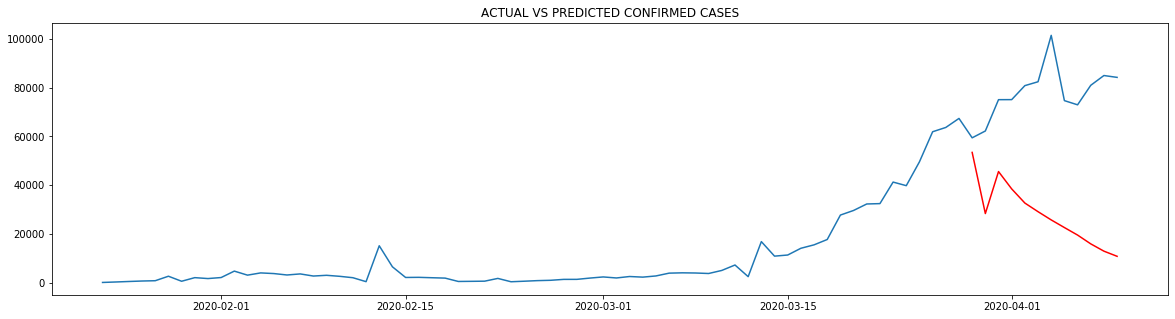

In [84]:
plt.figure(figsize=(20,5))
plt.plot(df_test.index, df_test['Confirmed'])
plt.plot(df_test.index, df_test['Predictions'], color='r')
plt.title("ACTUAL VS PREDICTED CONFIRMED CASES")
plt.savefig("figures/predictions/actual vs predicted confirmed cases.png")
plt.show()



In [85]:
train = df
scaler.fit(train)
train = scaler.transform(train)
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)
model.fit_generator(generator, epochs=200)
pred_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis=1)

Epoch 1/200
11/11 [==============================] - 0s 17ms/step - loss: 4.8123
Epoch 2/200
11/11 [==============================] - 0s 18ms/step - loss: 0.2059
Epoch 3/200
11/11 [==============================] - 0s 16ms/step - loss: 0.0991
Epoch 4/200
11/11 [==============================] - 0s 17ms/step - loss: 0.0676
Epoch 5/200
11/11 [==============================] - 0s 17ms/step - loss: 0.0451
Epoch 6/200
11/11 [==============================] - 0s 17ms/step - loss: 0.0222
Epoch 7/200
11/11 [==============================] - 0s 17ms/step - loss: 0.0200
Epoch 8/200
11/11 [==============================] - 0s 16ms/step - loss: 0.0108
Epoch 9/200
11/11 [==============================] - 0s 17ms/step - loss: 0.0067
Epoch 10/200
11/11 [==============================] - 0s 17ms/step - loss: 0.0073
Epoch 11/200
11/11 [==============================] - 0s 18ms/step - loss: 0.0056
Epoch 12/200
11/11 [==============================] - 0s 18ms/step - loss: 0.0048
Epoch 13/200
11/11 [=====

In [86]:
add_dates = [df.index[-1] + DateOffset(days=x) for x in range(0,13)] #just 30for convinience
future_dates = pd.DataFrame(index=add_dates[1:], columns=df.columns)
#print(future_dates)

In [87]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=future_dates.index, columns=['Predictions'])

df_proj = pd.concat([df,df_predict], axis=1)

In [88]:
#print(tabulate(df_proj[-12:], headers="keys"))

No handles with labels found to put in legend.


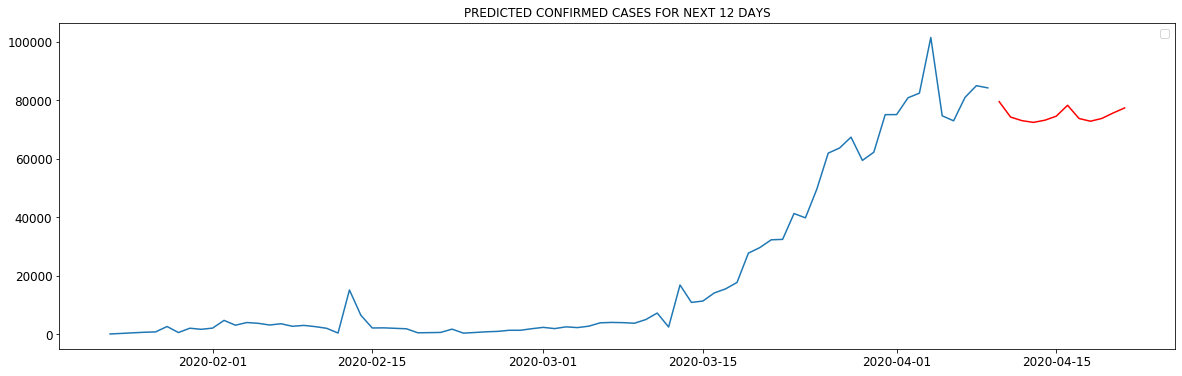

In [89]:
plt.figure(figsize=(20,6))
plt.title('COVID-19 Pedictions for next 12 days')
plt.plot(df_proj.index, df_proj['Confirmed'])
plt.plot(df_proj.index, df_proj['Predictions'], color="r")
plt.legend(loc="best", fontsize="large")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("PREDICTED CONFIRMED CASES FOR NEXT 12 DAYS")
plt.savefig("figures/predictions/predicted confirmed cases for next 12 days.png")
plt.show()
